In [1]:
# import libraries used during this exercise
# it may be necessary to uncomment the two following pip commands
#!pip3 install pandas
#!pip3 install matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# the core.py file contains the plottings and other pre-defined functions
from mlrcv.core import *
%matplotlib notebook
%matplotlib inline

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import typing
from mlrcv.core import *

class TreeNode:
    def __init__(self, node_id: str, max_degree: int):
        """
        This function initializes the TreeNode class (already implemented):

        Args:
            - node_id (str): node id to identiy the current node
            - max_degree (int): max degree of the tree

        Returns:
        """
        self.max_attr_gain = -np.inf
        self.attr_split = None
        self.attr_split_val = None
        self.node_class = None
        self.children = {}
        self.leaf = False
        self.node_id = node_id
        self.max_degree = max_degree
        self.root = None

    def infer_node(self, x: np.ndarray) -> float:
        """
        This function goes over the tree given the input data x and return the respective leaf class (only returns node_class after reaching a leaf):

        Args:
            - x (np.ndarray): input data x to be checked over the tree

        Returns:
            - node_class (float): respective leaf class given input x
        """
        
        if self.leaf:
            return self.node_class

        x_attr_val = x[self.attr_split]
        if x_attr_val <= self.attr_split_val:
            return self.children[0].infer_node(x)
        else:
            return self.children[1].infer_node(x)

#         return node_class

    def split_node(self, x: np.ndarray, y: np.ndarray, degree: int):
        """
        This function uses the current x and y data to split the tree nodes (left and right) given the information_gain
        calculated over the possible splits. Recursion stop condition will be when the current degree arrives at
        maximum degree (setting it as leaf):

        Args:
            - x (np.ndarray): input data x to be splited
            - y (np.ndarray): class labels of the input data x
            - degree (int): current node degree

        Returns:
        """
        
        if degree == self.max_degree:
            self.leaf = True
            #self.node_class = np.argmax(np.bincount(y))
            self.node_clas = np.argmax(np.bincount(y.astype(int)))
            return

        n_samples, n_features = x.shape
        max_attr_gain = -np.inf
        split_attr, split_val = None, None

        for attr in range(n_features):
            split_gain, split_value = self.attr_gain(x[:, attr], y)
            if split_gain > max_attr_gain:
                max_attr_gain = split_gain
                split_attr, split_val = attr, split_value

        if max_attr_gain == -np.inf:
            self.leaf = True
            self.node_class = np.argmax(np.bincount(y))
            return

        self.attr_split = split_attr
        self.attr_split_val = split_val
        x_left = x[x[:, split_attr] <= split_val]
        y_left = y[x[:, split_attr] <= split_val]
        x_right = x[x[:, split_attr] > split_val]
        y_right = y[x[:, split_attr] > split_val]

        self.children[0] = TreeNode(self.node_id + "0", self.max_degree)
        self.children[1] = TreeNode(self.node_id + "1", self.max_degree)

        self.children[0].split_node(x_left, y_left, degree + 1)
        self.children[1].split_node(x_right, y_right, degree + 1)

    def attr_gain(self, x_attr: np.ndarray, y: np.ndarray) -> (float, float):
        """
        This function calculates the attribute gain:

        Args:
            - x_attr (np.ndarray): input data x[attr] to be splitted
            - y (np.ndarray): labels of the input data x

        Returns:
            - split_gain (float): highest gain from the possible attributes splits
            - split_value (float): split value selected for x_attr attribute
        """
#         split_gain = None
#         split_value = None
        
        split_gain = -1
        split_value = None
        x_sorted = np.sort(x_attr)
        for i in range(len(x_sorted) - 1):
            split = (x_sorted[i] + x_sorted[i+1]) / 2
            y_l = y[x_attr < split]
            y_r = y[x_attr >= split]
            if len(y_l) == 0 or len(y_r) == 0:
                continue
            gain = self.information_gain(y, y_l, y_r)
            if gain > split_gain:
                split_gain = gain
                split_value = split
        return split_gain, split_value

        #return split_gain, split_value

    def information_gain(self, y: np.ndarray, y_l: np.ndarray, y_r: np.ndarray) -> float:
        """
        This function calculates the attribute gain from the candidate splits y_l and y_r:

        Args:
            - y (np.ndarray): the full labels of the current node
            - y_l (np.ndarray): labels of the candidate left node split
            - y_r (np.ndarray): labels of the candidate right node split

        Returns:
            - I (float): information gain from the candidate splits y_l and y_r
        """
        entropy_y = self.entropy(y)
        entropy_y_l = self.entropy(y_l)
        entropy_y_r = self.entropy(y_r)
    
        # calculate the weighted average entropy
        n = len(y)
        n_l = len(y_l)
        n_r = len(y_r)
        weighted_avg_entropy = (n_l/n)*entropy_y_l + (n_r/n)*entropy_y_r
        
        I = entropy_y - weighted_avg_entropy

        return I

    def entropy(self, y: np.ndarray) -> float:
        """
        This function calculates the entropy from the input labels set y:

        Args:
            - y (np.ndarray): the labels set to calculate the entropy

        Returns:
            - H (float): the entropy of the input labels set y
        """
        unique_labels, label_counts = np.unique(y, return_counts=True)
        ps = label_counts / len(y)
        H =  -np.sum([p * np.log2(p) for p in ps if p > 0])

        return H

# class DecisionTree:
#     def __init__(self, num_class: int, max_degree: int):
#         """
#         This function initializes the DecisionTree class (already implemented):

#         Args:
#             - num_class (int): number of class from your data
#             - max_degree (int): max degree of the tree

#         Returns:
#         """
#         self.root = None
#         self.max_degree = max_degree
#         self.num_class = num_class
    


    def predict_y(self, X: np.ndarray) -> np.ndarray:
        """
        This function predicts y_pred class from the input x:

        Args:
            - x (np.ndarray): input data to be predicted by the tree

        Returns:
            - y_pred (np.ndarray): tree predictions over input x
        """
        #y_pred = None
        y_pred  =  np.array([self.infer_node(x) for x in X])
        return y_pred

    def eval(self, x: np.ndarray, y: np.ndarray):
        """
        This function evaluate the model predicting y_pred from input x and calculating teh accuracy between y_pred and y:

        Args:
            - x (np.ndarray): input data to be predicted by the tree
            - y (np.ndarray): input class labels

        Returns:
            - acc (float): accuracy of the model
        """
        return accuracy(y, self.predict_y(x))
    
    def fit(self, x: np.ndarray, y: np.ndarray):
        """
        This function fits the decision tree with the training data x and labels y. Starting from root tree node,
        and iterate recursively over the nodes, split on left and right nodes:

        Args:
            - x (np.ndarray): the full labels of the current node
            - y (np.ndarray): labels of the candidate left node split

        Returns:

        """
        #self.root = TreeNode('zero',self.max_degree)
        #self.root.split_node(x,y,self.max_degree)
        #self.split_node(x,y,self.max_degree)
        self.root = self.split_node(x, y,self.max_degree)
        pass


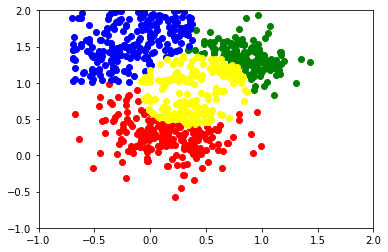

In [8]:
# Dataset read
df = pd.read_csv('data/random_forest.csv')
x = df.drop(columns=['class']).values
y = df['class'].values
num_class = 4
plot_model(x, y, None)

In [9]:
# already implemented this time :)
x_train, y_train, x_val, y_val = split_data(x, y)

In [10]:
#from mlrcv.decision_tree import *

d_tree = TreeNode('q',max_degree=2)


In [11]:
print('acc: ', d_tree.eval(x_val, y_val))



TypeError: '<=' not supported between instances of 'float' and 'NoneType'

In [ ]:
plot_model(x_val, y_val, d_tree)